In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 200)

#from lightgbm import LGBMRegressor
#from lightgbm.sklearn import LGBMRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import numpy as np

import shap

In [21]:
# create data file

#df_train = pd.read_csv("../data/train.csv")
#df_train.to_parquet("../data/train.parquet") 

#df_sample = df_train.sample(frac=0.01, random_state=42)
#df_sample.to_parquet("../data/train_sample_1pct.parquet")

In [22]:
df_train = pd.read_parquet("../data/train_sample_1pct.parquet")

In [23]:
print(df_train.columns.tolist())
df_train.head().T

['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']


,10478479,2240033,24966385,38721384,41464765
key,2010-01-16 20:06:00.000000168,2010-09-22 23:21:00.00000065,2013-10-17 18:40:14.0000001,2015-06-09 19:39:42.0000009,2012-05-01 07:16:59.0000001
fare_amount,3.3,6.5,5.0,40.5,7.7
pickup_datetime,2010-01-16 20:06:00 UTC,2010-09-22 23:21:00 UTC,2013-10-17 18:40:14 UTC,2015-06-09 19:39:42 UTC,2012-05-01 07:16:59 UTC
pickup_longitude,-73.953323,-73.985542,-73.999945,-73.974533,-73.952835
pickup_latitude,40.778532,40.738333,40.718097,40.756237,40.786351
dropoff_longitude,-73.953375,-74.00335,-73.999239,-73.923149,-73.974022
dropoff_latitude,40.772505,40.738935,40.723103,40.86721,40.762765
passenger_count,1,1,1,1,1


In [24]:
print(len(df_train))
print(df_train.isnull().sum())

554239
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    6
dropoff_latitude     6
passenger_count      0
dtype: int64


In [25]:
# 欠損値の削除
df_train = df_train.dropna()
df_train = df_train[df_train["fare_amount"] > 0].copy()

print(df_train.isnull().sum())
print(len(df_train))

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64
554182


In [26]:
# 非現実な乗車数のチェック
print(df_train["passenger_count"].value_counts().sort_index())


passenger_count
0      1985
1    383797
2     81456
3     24303
4     11807
5     39239
6     11593
7         1
8         1
Name: count, dtype: int64


In [27]:
# 非現実的な乗車人数（0人以下、および6人超）を除去
df_train = df_train[(df_train["passenger_count"] >= 1) & (df_train["passenger_count"] <= 6)]

In [28]:
# 非現実な乗車数のチェック
print(df_train["passenger_count"].value_counts().sort_index())

passenger_count
1    383797
2     81456
3     24303
4     11807
5     39239
6     11593
Name: count, dtype: int64


In [29]:
# 日時型に変換（もしまだであれば）
df_train["pickup_datetime"] = pd.to_datetime(df_train["pickup_datetime"])

# 年・月・日・曜日・時間帯などを抽出
df_train["year"] = df_train["pickup_datetime"].dt.year
df_train["month"] = df_train["pickup_datetime"].dt.month
df_train["weekday"] = df_train["pickup_datetime"].dt.weekday  # 月曜=0, 日曜=6
df_train["hour"] = df_train["pickup_datetime"].dt.hour

In [30]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # 緯度経度をラジアンに変換
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # 差分
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine式
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return 6371 * c  # 地球の半径6371kmを掛ける

# Haversine距離を新たに計算して列に追加
df_train["distance_km"] = haversine_distance(
    df_train["pickup_latitude"],
    df_train["pickup_longitude"],
    df_train["dropoff_latitude"],
    df_train["dropoff_longitude"]
)


In [31]:
def haversine_np(lat1, lon1, lat2, lon2):
    # 度→ラジアン変換
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c  # km単位

# 特定地点の座標（lat, lon）
locations = {
    "JFK": (40.6413, -73.7781),
    "LGA": (40.7769, -73.8740),
    "EWR": (40.6895, -74.1745),
    "Penn_Station": (40.7506, -73.9935),
    "Grand_Central": (40.7527, -73.9772),
    "Times_Square": (40.7580, -73.9855),
}

# 距離計算：pickup / dropoff 両方
for name, (lat, lon) in locations.items():
    df_train[f"pickup_distance_to_{name}"] = haversine_np(
        df_train["pickup_latitude"], df_train["pickup_longitude"],
        lat, lon
    )
    df_train[f"dropoff_distance_to_{name}"] = haversine_np(
        df_train["dropoff_latitude"], df_train["dropoff_longitude"],
        lat, lon
    )


In [32]:
# 緯度のみ変化 → 東西の移動
east_west = haversine_np(
    df_train["pickup_latitude"], df_train["pickup_longitude"],
    df_train["pickup_latitude"], df_train["dropoff_longitude"]
)

# 経度のみ変化 → 南北の移動
north_south = haversine_np(
    df_train["pickup_latitude"], df_train["dropoff_longitude"],
    df_train["dropoff_latitude"], df_train["dropoff_longitude"]
)

# 合成して Manhattan 距離に
df_train["manhattan_km"] = east_west + north_south


In [33]:
from sklearn.cluster import KMeans

# pickup位置クラスタ
pickup_coords = df_train[["pickup_latitude", "pickup_longitude"]]
kmeans_pickup = KMeans(n_clusters=25, random_state=42)
df_train["pickup_cluster"] = kmeans_pickup.fit_predict(pickup_coords)

# dropoff位置クラスタ
dropoff_coords = df_train[["dropoff_latitude", "dropoff_longitude"]]
kmeans_dropoff = KMeans(n_clusters=25, random_state=42)
df_train["dropoff_cluster"] = kmeans_dropoff.fit_predict(dropoff_coords)


#print(df_train["pickup_cluster"].value_counts().sort_index())
#print(df_train["dropoff_cluster"].value_counts().sort_index())


In [34]:
df_train["delta_latitude"] = df_train["dropoff_latitude"] - df_train["pickup_latitude"]
df_train["delta_longitude"] = df_train["dropoff_longitude"] - df_train["pickup_longitude"]

#df_train["path_efficiency"] = df_train["distance_km"] / df_train["manhattan_km"]
df_train["path_efficiency"] = df_train["distance_km"] / df_train["manhattan_km"].replace(0, np.nan)


df_train["pickup_vs_dropoff_to_JFK"] = (
    df_train["pickup_distance_to_JFK"] - df_train["dropoff_distance_to_JFK"]
)

# クラスタ別の平均距離
pickup_cluster_avg_fare = df_train.groupby("pickup_cluster")["fare_amount"].mean().rename("pickup_cluster_avg_fare")
df_train = df_train.join(pickup_cluster_avg_fare, on="pickup_cluster")


In [35]:
# JFKの緯度経度（40.6413, -73.7781）
jfk_lat, jfk_lon = 40.6413, -73.7781

df_train["is_jfk_pickup"] = (df_train["pickup_distance_to_JFK"] < 1.0).astype(int)
df_train["is_jfk_dropoff"] = (df_train["dropoff_distance_to_JFK"] < 1.0).astype(int)



In [36]:
dt = df_train["pickup_datetime"].dt

df_train["holiday_flag"] = (
    ((dt.month == 1) & (dt.day == 1)) |     # 元日
    ((dt.month == 7) & (dt.day == 4)) |     # 独立記念日
    ((dt.month == 12) & (dt.day == 25)) |   # クリスマス
    ((dt.month == 12) & (dt.day == 31))     # 大晦日
).astype(int)

print(df_train["holiday_flag"].value_counts())


holiday_flag
0    547962
1      4233
Name: count, dtype: int64


In [37]:
print(df_train.columns.tolist())
df_train.head().T

['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year', 'month', 'weekday', 'hour', 'distance_km', 'pickup_distance_to_JFK', 'dropoff_distance_to_JFK', 'pickup_distance_to_LGA', 'dropoff_distance_to_LGA', 'pickup_distance_to_EWR', 'dropoff_distance_to_EWR', 'pickup_distance_to_Penn_Station', 'dropoff_distance_to_Penn_Station', 'pickup_distance_to_Grand_Central', 'dropoff_distance_to_Grand_Central', 'pickup_distance_to_Times_Square', 'dropoff_distance_to_Times_Square', 'manhattan_km', 'pickup_cluster', 'dropoff_cluster', 'delta_latitude', 'delta_longitude', 'path_efficiency', 'pickup_vs_dropoff_to_JFK', 'pickup_cluster_avg_fare', 'is_jfk_pickup', 'is_jfk_dropoff', 'holiday_flag']


,10478479,2240033,24966385,38721384,41464765
key,2010-01-16 20:06:00.000000168,2010-09-22 23:21:00.00000065,2013-10-17 18:40:14.0000001,2015-06-09 19:39:42.0000009,2012-05-01 07:16:59.0000001
fare_amount,3.3,6.5,5.0,40.5,7.7
pickup_datetime,2010-01-16 20:06:00+00:00,2010-09-22 23:21:00+00:00,2013-10-17 18:40:14+00:00,2015-06-09 19:39:42+00:00,2012-05-01 07:16:59+00:00
pickup_longitude,-73.953323,-73.985542,-73.999945,-73.974533,-73.952835
pickup_latitude,40.778532,40.738333,40.718097,40.756237,40.786351
dropoff_longitude,-73.953375,-74.00335,-73.999239,-73.923149,-73.974022
dropoff_latitude,40.772505,40.738935,40.723103,40.86721,40.762765
passenger_count,1,1,1,1,1
year,2010,2010,2013,2015,2012
month,1,9,10,6,5


In [38]:
features = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'year',
    'month',
    'weekday',
    'hour',
    'distance_km',
    'manhattan_km',
    'pickup_distance_to_JFK',
    'dropoff_distance_to_JFK',
    'pickup_distance_to_LGA',
    'dropoff_distance_to_LGA',
    'pickup_distance_to_EWR',
    'dropoff_distance_to_EWR',
    'pickup_distance_to_Penn_Station',
    'dropoff_distance_to_Penn_Station',
    'pickup_distance_to_Grand_Central',
    'dropoff_distance_to_Grand_Central',
    'pickup_distance_to_Times_Square',
    'dropoff_distance_to_Times_Square',
    'holiday_flag',
    'pickup_cluster',
    'dropoff_cluster',
    "delta_latitude",
    "delta_longitude",
    "path_efficiency",
    "pickup_vs_dropoff_to_JFK",
    "pickup_cluster_avg_fare",
    'is_jfk_pickup',
    'is_jfk_dropoff',
]


X = df_train[features]

# y = df_train["fare_amount"]
y = np.log1p(df_train["fare_amount"])


kf = KFold(n_splits=5, shuffle=True, random_state=42)

mae_scores = []
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     model = LGBMRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)

#     model.fit(
#         X_train, y_train,
# #        eval_set=[(X_val, y_val)],
#         eval_set=[(X_val, y_val.values)],  # ← ここが重要

#         eval_metric="rmse",
#         early_stopping_rounds=50,
#         verbose=100
#     )

    model = LGBMRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val.values)],
        eval_metric="rmse",
        callbacks=[
            early_stopping(50),
            log_evaluation(100)
        ]
    )
    
    
#    y_pred = model.predict(X_val)
#    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    y_pred_log = model.predict(X_val)
    y_pred = np.expm1(y_pred_log)
    y_val_orig = np.expm1(y_val)

    rmse = np.sqrt(mean_squared_error(y_val_orig, y_pred))
    mae = mean_absolute_error(y_val_orig, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)

print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
print(f"Mean MAE : {np.mean(mae_scores):.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5701
[LightGBM] [Info] Number of data points in the train set: 441756, number of used features: 33
[LightGBM] [Info] Start training from score 2.333061
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.232464	valid_0's l2: 0.0540396
[200]	valid_0's rmse: 0.229202	valid_0's l2: 0.0525334
[300]	valid_0's rmse: 0.227782	valid_0's l2: 0.0518846
[400]	valid_0's rmse: 0.226746	valid_0's l2: 0.0514137
[500]	valid_0's rmse: 0.22614	valid_0's l2: 0.0511394
[600]	valid_0's rmse: 0.22558	valid_0's l2: 0.0508863
[700]	valid_0's rmse: 0.225374	valid_0's l2: 0.0507936
[800]	valid_0's rmse: 0.225209	valid_0's l2: 0.0507192
[900]	valid_0's rmse: 0.225045	valid_0's l2: 0.0506452
[1000]	valid_0's rmse: 0.224909	valid_0

In [39]:
import pandas as pd
import numpy as np

# 誤差を計算
errors = np.abs(y_val - y_pred)

# ビンの定義（誤差の幅を段階的に）
bins = [0, 1, 2, 3, 5, 10, 20, np.inf]
labels = ['0–1$', '1–2$', '2–3$', '3–5$', '5–10$', '10–20$', '20+$']

# ビンごとにカウント
error_bins = pd.cut(errors, bins=bins, labels=labels, right=False)
error_summary = error_bins.value_counts().sort_index().to_frame(name='件数')

# 割合も追加
error_summary['割合(%)'] = (error_summary['件数'] / len(errors) * 100).round(2)
error_summary['累積割合(%)'] = error_summary['割合(%)'].cumsum().round(2)

# 表示
display(error_summary)


,件数,割合(%),累積割合(%)
fare_amount,,,
0–1$,35,0.03,0.03
1–2$,325,0.29,0.32
2–3$,7891,7.15,7.47
3–5$,31698,28.70,36.17
5–10$,45171,40.90,77.07
10–20$,17720,16.05,93.12
20+$,7599,6.88,100.00


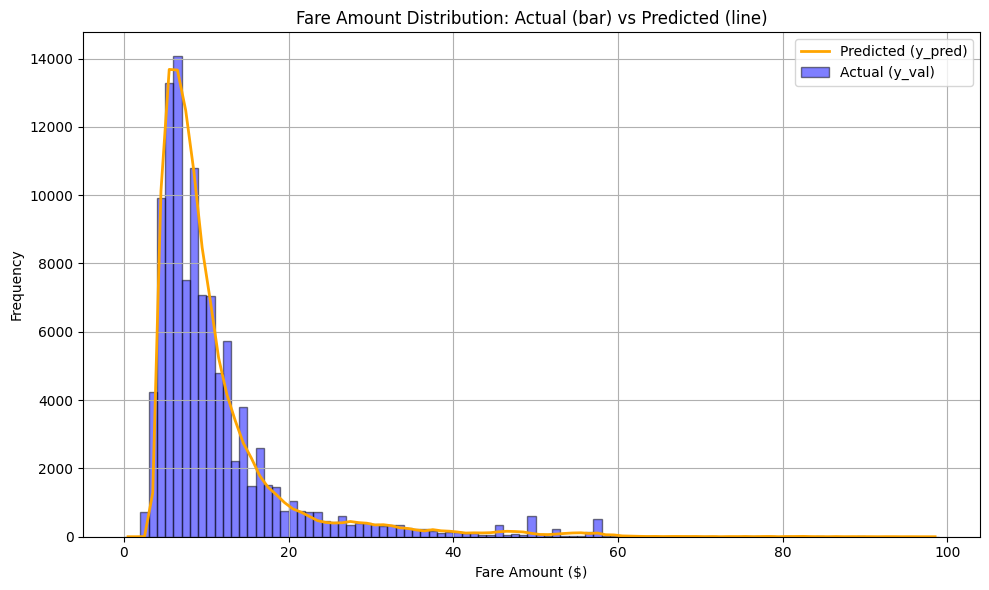

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# ビン設定（0〜100ドル、1ドル刻み）
bins = np.arange(0, 100, 1)

# 実測値のヒストグラム（棒）
actual_counts, _ = np.histogram(y_val_orig, bins=bins)

# 予測値のヒストグラム（折れ線用に中心をとる）
pred_counts, _ = np.histogram(y_pred, bins=bins)
bin_centers = bins[:-1] + 0.5

# 描画
plt.figure(figsize=(10, 6))

# 実測値: 棒グラフ
plt.bar(bin_centers, actual_counts, width=1.0, alpha=0.5, label='Actual (y_val)', color='blue', edgecolor='black')

# 予測値: 折れ線グラフ
plt.plot(bin_centers, pred_counts, label='Predicted (y_pred)', color='orange', linewidth=2)

plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.title('Fare Amount Distribution: Actual (bar) vs Predicted (line)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

shap_df = pd.DataFrame(shap_values, columns=X_val.columns, index=X_val.index)

display(shap_df.head())

shap_summary_df = pd.DataFrame({
    'Mean(|SHAP|)': shap_df.abs().mean(),
}).sort_values(by='Mean(|SHAP|)', ascending=False)

display(shap_summary_df)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,distance_km,...,holiday_flag,pickup_cluster,dropoff_cluster,delta_latitude,delta_longitude,path_efficiency,pickup_vs_dropoff_to_JFK,pickup_cluster_avg_fare,is_jfk_pickup,is_jfk_dropoff
37752606,0.004047,-0.015732,-0.010489,-0.014069,-0.005383,0.066758,-0.012264,-0.029338,-0.014691,-0.517272,...,0.000220,-9.391531e-05,0.000503,-0.001867,-0.024384,-0.059542,-0.073697,0.000176,-0.000004,0.000008
48114909,0.002579,-0.015706,-0.009068,0.001973,-0.005097,-0.067508,-0.017907,-0.029647,0.025837,-0.227073,...,0.000444,1.686573e-07,0.000459,-0.005393,-0.020639,-0.013614,-0.042418,0.000257,-0.000001,0.000006
24432224,0.009293,-0.028983,-0.010652,0.003185,0.013049,-0.069973,-0.016545,-0.000814,-0.034287,0.128939,...,0.000265,5.150105e-05,0.000456,-0.007755,0.021627,0.013087,-0.047847,0.000130,-0.000006,0.000054
4851451,-0.002357,-0.000292,0.007107,-0.010219,-0.003170,0.016769,0.066302,0.024289,0.022063,0.255504,...,0.000420,-6.513427e-06,0.000411,-0.004348,-0.007943,-0.007135,-0.017642,0.000178,0.000002,0.000005
5478888,-0.002477,-0.004373,-0.000041,-0.001716,-0.006671,-0.055408,-0.005686,0.013244,0.030361,-0.543040,...,0.000446,-1.169089e-05,0.000457,-0.002249,-0.011234,-0.035497,-0.068406,0.000225,-0.000002,0.000003


,Mean(|SHAP|)
distance_km,0.339100
year,0.072918
hour,0.039711
pickup_vs_dropoff_to_JFK,0.037369
weekday,0.018612
month,0.018098
dropoff_distance_to_JFK,0.015037
path_efficiency,0.014357
delta_longitude,0.014307
manhattan_km,0.012516


In [42]:
import pandas as pd
import numpy as np

# 実測値・予測値が Series 形式で存在している前提
results_df = pd.DataFrame({
    "actual_fare": y_val_orig,
    "predicted_fare": y_pred
})

# 絶対誤差列を追加
results_df["abs_error"] = np.abs(results_df["actual_fare"] - results_df["predicted_fare"])

# fare_amount > 40 の中で誤差が大きい順に並べる
high_fare_errors = results_df[results_df["actual_fare"] > 40].sort_values(by="abs_error", ascending=False)

# 上位10件を表示（必要に応じて変更可）
print(high_fare_errors.head(10))


          actual_fare  predicted_fare   abs_error
20525777       285.00       89.347048  195.652952
39287436       197.07       11.356239  185.713761
14890236       192.66       19.177278  173.482722
225249         215.00       50.372494  164.627506
28971067       169.50        8.970626  160.529374
37241181       161.80        6.081779  155.718221
91906          150.00        6.279855  143.720145
46165206       150.00       12.341449  137.658551
31173664       134.00       11.662716  122.337284
37454597       171.07       49.323458  121.746542


In [44]:
import optuna
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial):
    # チューニング対象のパラメータを提案
    params = {
        "n_estimators": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 31, 127),
        "max_depth": trial.suggest_int("max_depth", 5, 15),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "random_state": 42,
        "n_jobs": -1,
    }

    # KFoldによるスコアの平均を最小化対象に
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = LGBMRegressor(**params)

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            callbacks=[early_stopping(50), log_evaluation(0)]
        )

        y_pred = model.predict(X_val)
        y_val_orig = np.expm1(y_val)
        y_pred_orig = np.expm1(y_pred)
        rmse = np.sqrt(mean_squared_error(y_val_orig, y_pred_orig))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

# 実行：5トライだけ
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

# 結果の表示
print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)


[I 2025-05-12 00:03:20,745] A new study created in memory with name: no-name-d5df8131-01f7-45ad-aefe-fc98d9cf7b39


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5701
[LightGBM] [Info] Number of data points in the train set: 441756, number of used features: 33
[LightGBM] [Info] Start training from score 2.333061
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 0.224216	valid_0's l2: 0.0502726
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5701
[LightGBM] [Info] Number of data points in the train set: 441756, number of used features: 33
[LightGBM] [Info] Start training from score 2.332482
Training until validat

[I 2025-05-12 00:05:24,985] Trial 0 finished with value: 4.160087723923229 and parameters: {'learning_rate': 0.05013359656029948, 'num_leaves': 103, 'max_depth': 15, 'subsample': 0.884291520648791, 'colsample_bytree': 0.854069912990891}. Best is trial 0 with value: 4.160087723923229.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5701
[LightGBM] [Info] Number of data points in the train set: 441756, number of used features: 33
[LightGBM] [Info] Start training from score 2.333061
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2025-05-12 00:06:42,466] Trial 1 finished with value: 4.1653362063338015 and parameters: {'learning_rate': 0.08913141388709388, 'num_leaves': 104, 'max_depth': 7, 'subsample': 0.8535894773924497, 'colsample_bytree': 0.9792592733128602}. Best is trial 0 with value: 4.160087723923229.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5701
[LightGBM] [Info] Number of data points in the train set: 441756, number of used features: 33
[LightGBM] [Info] Start training from score 2.333061
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.22925	valid_0's l2: 0.0525556
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006543 seconds.
You can set `force_row_wi

[I 2025-05-12 00:08:19,704] Trial 2 finished with value: 4.27459507363386 and parameters: {'learning_rate': 0.012488179235675415, 'num_leaves': 57, 'max_depth': 7, 'subsample': 0.9146140242841178, 'colsample_bytree': 0.8881061259726888}. Best is trial 0 with value: 4.160087723923229.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5701
[LightGBM] [Info] Number of data points in the train set: 441756, number of used features: 33
[LightGBM] [Info] Start training from score 2.333061
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[574]	valid_0's rmse: 0.224408	valid_0's l2: 0.0503589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5701
[LightGBM] [Info] Number of data points in the train set: 441756, number of used features: 33
[LightGBM] [Info] Start training from score 2.332482
Training until validation scores do

[I 2025-05-12 00:09:45,912] Trial 3 finished with value: 4.154756427153575 and parameters: {'learning_rate': 0.07236738721611095, 'num_leaves': 86, 'max_depth': 13, 'subsample': 0.9075270781965052, 'colsample_bytree': 0.7735057711452333}. Best is trial 3 with value: 4.154756427153575.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5701
[LightGBM] [Info] Number of data points in the train set: 441756, number of used features: 33
[LightGBM] [Info] Start training from score 2.333061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2025-05-12 00:10:39,980] Trial 4 finished with value: 4.197000512382806 and parameters: {'learning_rate': 0.058779440836398786, 'num_leaves': 109, 'max_depth': 5, 'subsample': 0.8186145296988703, 'colsample_bytree': 0.7785951924024039}. Best is trial 3 with value: 4.154756427153575.


Best RMSE: 4.154756427153575
Best params: {'learning_rate': 0.07236738721611095, 'num_leaves': 86, 'max_depth': 13, 'subsample': 0.9075270781965052, 'colsample_bytree': 0.7735057711452333}


In [46]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
import numpy as np

best_params = {
    'learning_rate': 0.07236738721611095,
    'num_leaves': 86,
    'max_depth': 13,
    'subsample': 0.9075270781965052,
    'colsample_bytree': 0.7735057711452333
}

# 共通設定
model = LGBMRegressor(
    n_estimators=1000,
    random_state=42,
    **best_params
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scores = []
rmse_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        callbacks=[early_stopping(50), log_evaluation(100)]
    )

    y_pred_log = model.predict(X_val)
    y_pred = np.expm1(y_pred_log)
    y_val_orig = np.expm1(y_val)

    rmse = np.sqrt(mean_squared_error(y_val_orig, y_pred))
    mae = mean_absolute_error(y_val_orig, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)

print(f"Mean RMSE: {np.mean(rmse_scores):.4f}")
print(f"Mean MAE : {np.mean(mae_scores):.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5701
[LightGBM] [Info] Number of data points in the train set: 441756, number of used features: 33
[LightGBM] [Info] Start training from score 2.333061
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.230191	valid_0's l2: 0.0529879
[200]	valid_0's rmse: 0.226824	valid_0's l2: 0.0514493
[300]	valid_0's rmse: 0.225635	valid_0's l2: 0.0509112
[400]	valid_0's rmse: 0.224973	valid_0's l2: 0.050613
[500]	valid_0's rmse: 0.224597	valid_0's l2: 0.0504437
[600]	valid_0's rmse: 0.224438	valid_0's l2: 0.0503725
Early stopping, best iteration is:
[574]	valid_0's rmse: 0.224408	valid_0's l2: 0.0503589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006421 seconds.
You can s